# Example Notebook for none-regressive TCN-TCN model

In [1]:
from tcn_sequence_models.data_processing.preprocessor import Preprocessor
from tcn_sequence_models.models import TCN_TCN_Attention
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import os
from tcn_sequence_models.utils.scaling import inverse_scale_sequences
import numpy as np

2022-07-06 13:46:26.689234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/michael/Projects/TCN_Seq2Seq/venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [2]:
#set config_path to a path on your system. There, the model and preprocessor configs
# will be saved to.
config_path = "./config_TCN_TCN_none_attention"
os.makedirs(name=config_path, exist_ok=True)

## Load and process data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
df = pd.read_csv(url)

In [4]:
time_col = 'DateTime'
df[time_col]= pd.to_datetime(df[time_col])

In [5]:
# Define features to use
features_input_encoder = [
    "Temperature",
    "Humidity",
    "Wind Speed",
    "general diffuse flows",
    "diffuse flows"
]

features_input_decoder = [
]

feature_target = "Zone 1 Power Consumption"

In [6]:
# Add temporal encodings. Possible are: 'seasons', 'months', 'weekdays' and 'hours'
temporal_encoding_modes = ["weekdays", "hours"]

In [7]:
split_ratio = 0.7
input_seq_len = 200
output_seq_len = 50
# Here use the none-regressive model. If you want to use the auto-regressive model
# with teacher-forcing, set it to True
autoregressive = False

In [8]:
preprocessor = Preprocessor(df)

In [9]:
# split_date = datetime.date(2019, 1, 1)
preprocessor.process(
    features_input_encoder,
    features_input_decoder,
    feature_target,
    input_seq_len,
    output_seq_len,
    model_type="tcn_tcn",
    time_col=time_col,
    split_ratio = split_ratio,
    split_date = None,
    temporal_encoding_modes=temporal_encoding_modes,
    autoregressive=autoregressive,
    )

In [10]:
X_train, y_train, X_val, y_val = preprocessor.train_test_split(split_ratio)

## Create model and fit it

In [13]:
from tensorflow.keras.optimizers import Adam

model = TCN_TCN_Attention()

model.build(
    num_layers_tcn = None,
    num_filters = 4,
    kernel_size = 3,
    dilation_base = 2,
    dropout_rate = 0.2,
    key_size = 4,
    value_size = 4,
    num_attention_heads = 2,
    neurons_output = [16],
    activation = "relu",
    kernel_initializer = "he_normal",
    batch_norm_tcn = True,
    layer_norm_tcn = False,
    autoregressive=autoregressive,
    padding_encoder='same',
    padding_decoder='same')
model.compile(optimizer=Adam(learning_rate=0.0003, decay=1e-3))


In [15]:
cb_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train,
          y_train,
          (X_val, y_val),
          epochs=10,
          batch_size=64,
          callbacks = cb_early_stopping
          )

Epoch 1/10
568/568 [==============================] - 23s 40ms/step - loss: 0.5053 - val_loss: 0.4081
Epoch 2/10
568/568 [==============================] - 21s 37ms/step - loss: 0.3657 - val_loss: 0.3078
Epoch 3/10
568/568 [==============================] - 21s 37ms/step - loss: 0.3017 - val_loss: 0.2633
Epoch 4/10
568/568 [==============================] - 21s 37ms/step - loss: 0.2681 - val_loss: 0.2382
Epoch 5/10
568/568 [==============================] - 21s 38ms/step - loss: 0.2460 - val_loss: 0.2174
Epoch 6/10
568/568 [==============================] - 21s 37ms/step - loss: 0.2291 - val_loss: 0.1997
Epoch 7/10
568/568 [==============================] - 21s 37ms/step - loss: 0.2169 - val_loss: 0.1884
Epoch 8/10
568/568 [==============================] - 21s 37ms/step - loss: 0.2064 - val_loss: 0.1812
Epoch 9/10
568/568 [==============================] - 21s 37ms/step - loss: 0.1990 - val_loss: 0.1769
Epoch 10/10
568/568 [==============================] - 21s 37ms/step - loss: 0.195

## Make predictions

In [32]:
y_pred = model.predict(X_val)

In [33]:
y_pred_unscaled = inverse_scale_sequences(y_pred, preprocessor.scaler_y)
y_val_unscaled = inverse_scale_sequences(np.expand_dims(y_val, axis=-1),
                                                        preprocessor.scaler_y)

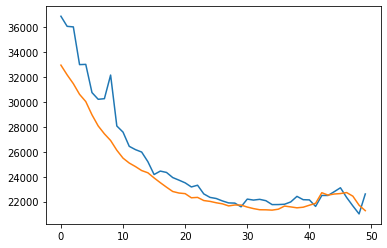

In [36]:
plt.plot(y_pred_unscaled[10000])
plt.plot(y_val_unscaled[10000])
plt.show()

## Save the preprocessor and the model

In [22]:
preprocessor.save_preprocessor_config(save_path=config_path)

In [23]:
model.save_model(config_path)

## Load the saved preprocessor and model

In [24]:
preprocessor_loaded = Preprocessor(df)
preprocessor_loaded.load_preprocessor_config(load_path=config_path)

In [25]:
# Load with the intention to only use the model for inference. If the model shall be
# trained, use process_from_config_training() and the get the training data with the
# train_test_split() method.
preprocessor_loaded.process_from_config_inference()

In [26]:
model_loaded = TCN_TCN_Attention()

In [27]:
model_loaded.load_model(config_path, preprocessor_loaded.X, is_training_data=False)
# If you use the autoregressive model:
# model_loaded.load_model(config_path, X_init[:3],
# is_training_data=True)

In [28]:
y_pred = model_loaded.predict(preprocessor_loaded.X)

In [29]:
y_pred_unscaled = inverse_scale_sequences(y_pred, preprocessor_loaded.scaler_y)
y_true_unscaled = inverse_scale_sequences(np.expand_dims(preprocessor.y, axis=-1),
                                                        preprocessor_loaded.scaler_y)

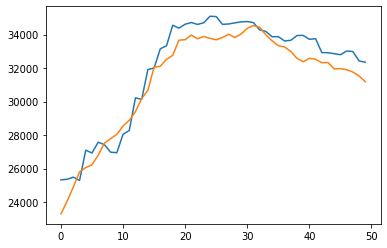

In [30]:
plt.plot(y_pred_unscaled[1000])
plt.plot(y_true_unscaled[1000])
plt.show()

## Run bayessian optimizer to find the optimal hyperparameters

In [31]:
model.parameter_search(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size = 64,
        results_path = "./search_4",
        patience=3,
        loss = "mse",
        max_trials = 10,
        executions_per_trial = 1,
        num_filters = [4, 6, 8],
        neurons_output = [16],
        kernel_size = [5, 9, 13, 17],
        dilation_base = [2],
        dropout_rate = [0.1, 0.2, 0.3],
        key_value_size = [4, 6, 8],
        num_attention_heads = [1, 2],
        activation = ["elu"],
        kernel_initializer = ["he_normal"],
        batch_norm_tcn = [False],
        layer_norm_tcn = [True],
        padding_encoder = ['same', 'causal'],
        padding_decoder = ['same', 'causal']
    )

Trial 1 Complete [00h 01m 10s]
val_loss: 0.1985245645046234

Best val_loss So Far: 0.1985245645046234
Total elapsed time: 00h 01m 10s
INFO:tensorflow:Oracle triggered exit
